## This notebook prepares for decoding (both 1D and 2D)
### Use this notebook to run session/day of each dataset from new animal

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [4]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
from replay_trajectory_classification import ClusterlessClassifier



import pprint
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import EpochPos,TrialChoice,Decode,DecodeResultsLinear
from spyglass.shijiegu.decodeHelpers import (thresholder_sort,runSessionNames,populateUnitMarks,intersectValidIntervals)

[2024-07-02 21:01:35,061][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
02-Jul-24 21:01:35 Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-07-02 21:01:35,146][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306
02-Jul-24 21:01:35 Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [5]:
from spyglass.shijiegu.decodeHelpers import decodePrepMasterSession

## Table stream:
#### The thresholder sorter will fill `SpikeSorting`, then we fill `Curation`, `UnitMarks`
### 1. The final product is `UnitMarksIndicator`, which include spike and location

In [95]:
nwb_copy_file_name = 'eliot20221017_.nwb'

In [96]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']


In [76]:
e = 0
sorting_keys = thresholder_sort(nwb_copy_file_name,session_interval[e],True)

0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
4
inserting into IntervalList
done inserting into IntervalList
5
inserting into IntervalList
done inserting into IntervalList
13
inserting into IntervalList
done inserting into IntervalList
14
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
23
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done insertin

[11:23:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:23:35 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:23:40][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:23:40 Saving sorting results...
[11:23:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 13, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:23:43 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 13, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:23:47][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:23:47 Saving sorting results...
[11:23:50][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 14, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:23:50 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 14, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:23:56][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:23:56 Saving sorting results...
[11:23:59][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:23:59 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_16_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:24:04][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:24:04 Saving sorting results...
[11:24:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 17, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:24:08 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 17, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_17_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:24:13][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:24:13 Saving sorting results...
[11:24:16][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 20, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:24:16 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 20, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_20_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:24:21][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:24:21 Saving sorting results...
[11:24:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 23, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:24:26 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 23, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_23_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:24:30][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:24:30 Saving sorting results...
[11:24:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 26, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:24:35 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 26, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_26_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:24:39][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:24:39 Saving sorting results...
[11:24:44][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 27, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:24:44 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 27, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_27_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:24:49][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:24:49 Saving sorting results...
[11:24:52][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:24:52 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_28_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:24:57][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:24:57 Saving sorting results...
[11:25:02][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 29, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:25:02 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 29, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_29_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:25:06][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:25:06 Saving sorting results...
[11:25:12][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:25:12 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:25:17][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:25:17 Saving sorting results...
[11:25:22][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:25:22 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_30_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:25:27][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:25:27 Saving sorting results...
[11:25:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 31, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:25:31 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 31, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_31_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:25:36][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:25:36 Saving sorting results...
[11:25:40][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 4, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:25:40 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 4, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_4_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:25:45][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:25:45 Saving sorting results...
[11:25:49][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 5, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 11:25:49 Running spike sorting on {'nwb_file_name': 'eliot20221020_.nwb', 'sort_group_id': 5, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221020_.nwb_02_Seq2Session1_5_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2277 [00:00<?, ?it/s]

[11:25:54][INFO] Spyglass: Saving sorting results...
03-Jul-24 11:25:54 Saving sorting results...


In [15]:
mark_parameters_keys = populateUnitMarks(sorting_keys)

IntegrityError: Cannot add or update a child row: a foreign key constraint fails (`spikesorting_curation`.`curation`, CONSTRAINT `curation_ibfk_1` FOREIGN KEY (`nwb_file_name`, `sort_group_id`, `sort_interval_name`, `preproc_params_name`, `team_name`, `sorter`, `sorter_para)

In [57]:
(SpikeSorting & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
eliot20221018_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_7227afd4_spikesorting,1685393578
eliot20221018_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ac697906_spikesorting,1685393716
eliot20221018_.nwb,0,05_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_05_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_05_Seq2Session3_0_franklab_tetrode_hippocampus_525186ae_spikesorting,1685393752
eliot20221018_.nwb,0,05_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_05_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/eliot20221018_.nwb_05_Seq2Session3_0_franklab_tetrode_hippocampus_a0238c55_spikesorting,1720022846
eliot20221018_.nwb,0,07_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_07_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_07_Seq2Session4_0_franklab_tetrode_hippocampus_990215ea_spikesorting,1685393944
eliot20221018_.nwb,0,09_Seq2Session5,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_09_Seq2Session5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_09_Seq2Session5_0_franklab_tetrode_hippocampus_f88489d6_spikesorting,1685394335
eliot20221018_.nwb,0,11_Seq2Session6,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_11_Seq2Session6_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_11_Seq2Session6_0_franklab_tetrode_hippocampus_a7daa7f8_spikesorting,1685394903
eliot20221018_.nwb,2,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_abb0318c_spikesorting,1685393591
eliot20221018_.nwb,2,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_04_Seq2Session2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_04_Seq2Session2_2_franklab_tetrode_hippocampus_eee7a753_spikesorting,1685393718
eliot20221018_.nwb,2,05_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221018_.nwb_05_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221018_.nwb_05_Seq2Session3_2_franklab_tetrode_hippocampus_65b94efc_spikesorting,1685393765


In [60]:
sorting_keys[0]

{'nwb_file_name': 'eliot20221018_.nwb',
 'sort_interval_name': '05_Seq2Session3',
 'sort_group_id': 0,
 'preproc_params_name': 'franklab_tetrode_hippocampus',
 'team_name': 'Shijie Gu',
 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only',
 'sorter': 'clusterless_thresholder',
 'sorter_params_name': 'default',
 'curation_id': 0,
 'parent_curation_id': -1,
 'description': '',
 'curation_labels': {},
 'merge_groups': [],
 'quality_metrics': {},
 'time_of_creation': 1719979418}

In [59]:
Curation.insert_curation(sorting_keys[0])

QuerySyntaxError: ('You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near \'})AND(`merge_groups`="[]")AND(`quality_metrics`={})AND(`time_of_creation`=171997\' at line 1', 'SELECT `curation_id`,`nwb_file_name`,`sort_group_id`,`sort_interval_name`,`preproc_params_name`,`team_name`,`sorter`,`sorter_params_name`,`artifact_removed_interval_list_name` FROM `spikesorting_curation`.`curation` WHERE ( (`nwb_file_name`="eliot20221018_.nwb")AND(`sort_interval_name`="05_Seq2Session3")AND(`sort_group_id`=0)AND(`preproc_params_name`="franklab_tetrode_hippocampus")AND(`team_name`="Shijie Gu")AND(`artifact_removed_interval_list_name`="eliot20221018_.nwb_05_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only")AND(`sorter`="clusterless_thresholder")AND(`sorter_params_name`="default")AND(`curation_id`=0)AND(`parent_curation_id`=-1)AND(`description`="")AND(`curation_labels`={})AND(`merge_groups`="[]")AND(`quality_metrics`={})AND(`time_of_creation`=1719979418))')

In [11]:
positionIntervalList = (
        IntervalList &
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]})

marks_selection = ((UnitMarks & mark_parameters_keys) * positionIntervalList)
marks_selection = (pd.DataFrame(marks_selection)
                   .loc[:, marks_selection.primary_key]
                   .to_dict('records'))
UnitMarksIndicatorSelection.insert(marks_selection, skip_duplicates=True)

NameError: name 'mark_parameters_keys' is not defined

In [34]:
UnitMarksIndicatorSelection() & {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,interval_list_name descriptive name of this interval list,sampling_rate
0,eliot20221026_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,2,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,4,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,5,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,13,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,14,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,16,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,17,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,20,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,eliot20221026_.nwb,26,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221026_.nwb_06_Seq2Session3_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0


In [35]:
UnitMarksIndicator.populate(marks_selection)

[11:06:29][INFO] Spyglass: Writing new NWB file eliot20221026_7TPPIRYHHH.nwb
13-Jun-24 11:06:29 Writing new NWB file eliot20221026_7TPPIRYHHH.nwb
[11:06:39][INFO] Spyglass: Writing new NWB file eliot20221026_SFUUZ8RY6O.nwb
13-Jun-24 11:06:39 Writing new NWB file eliot20221026_SFUUZ8RY6O.nwb
[11:06:50][INFO] Spyglass: Writing new NWB file eliot20221026_0V6U6VYUVH.nwb
13-Jun-24 11:06:50 Writing new NWB file eliot20221026_0V6U6VYUVH.nwb
[11:06:59][INFO] Spyglass: Writing new NWB file eliot20221026_UAMIWDZTKI.nwb
13-Jun-24 11:06:59 Writing new NWB file eliot20221026_UAMIWDZTKI.nwb
[11:07:09][INFO] Spyglass: Writing new NWB file eliot20221026_1C3YXY3ARC.nwb
13-Jun-24 11:07:09 Writing new NWB file eliot20221026_1C3YXY3ARC.nwb
[11:07:20][INFO] Spyglass: Writing new NWB file eliot20221026_R8CXFFFB1O.nwb
13-Jun-24 11:07:20 Writing new NWB file eliot20221026_R8CXFFFB1O.nwb
[11:07:29][INFO] Spyglass: Writing new NWB file eliot20221026_ETFUVPVM1G.nwb
13-Jun-24 11:07:29 Writing new NWB file eliot20

In [40]:
marks = (UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name,
    'interval_list_name': position_interval[e],   
}).fetch_xarray()
marks.shape

(850920, 4, 15)

After you get the marks, it is important to visualize them to make sure they look right. We can use the `plot_all_marks` method of UnitMarksIndicator to quickly plot each mark feature against the other for each electrode.

Here it is important to look for things that look overly correlated (strong diagonal on the off-diagonal plots) and for extreme amplitudes.

In [60]:
UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name  
}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,interval_list_name descriptive name of this interval list,sampling_rate,analysis_file_name name of the file,marks_indicator_object_id
0,eliot20221021_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 1 valid times,500.0,eliot20221021_WGF6BP68X4.nwb,2cc12b9c-36c3-4ff7-9926-6f1f7f4b253b
0,eliot20221021_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,eliot20221021_KSZXMG8HXC.nwb,e0756d8a-ec68-4a94-8a97-dd73aff21fd3
0,eliot20221021_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 3 valid times,500.0,eliot20221021_KUCG14I286.nwb,2830f6ce-3e0d-458a-9489-7d4a48ef97f2
0,eliot20221021_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 3 valid times,500.0,eliot20221021_JLRITVHF47.nwb,f9468067-942f-41a7-a7fc-709ebfeb8887
0,eliot20221021_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 5 valid times,500.0,eliot20221021_91C8IH2C5R.nwb,8cdabffd-dafd-4824-a44c-50bb2f24d928
0,eliot20221021_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,eliot20221021_RIETOT7U5K.nwb,aca05b4e-4f53-42fe-a0b2-d6fddd39a31c
0,eliot20221021_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 7 valid times,500.0,eliot20221021_K0CZOW21D5.nwb,19d1e9dd-ad97-45ad-a7aa-1a402888442a
0,eliot20221021_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 7 valid times,500.0,eliot20221021_4FQP1OLVSM.nwb,e1b06fa3-a2be-43ef-b448-dd663c7b3b52
0,eliot20221021_.nwb,2,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,pos 1 valid times,500.0,eliot20221021_CM1WNMZXQB.nwb,0b4462e7-2f78-4e6a-9992-417c1ef684fb
0,eliot20221021_.nwb,2,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221021_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,eliot20221021_TXO8YJKQOG.nwb,87278124-ae40-4afd-8b54-2af602e2bf32


## 2. Position

After the marks look good, you'll need to load/populate the 2D position data. This comes from the `IntervalPositionInfo` table. See the position tutorial for more information. Note that we will need to upsample the position data (which is done here via the `default_decoding` parameters) to match the sampling frequency that we intend to decode in (2 ms time bins or 500 Hz sampling rate)

Next we populate/load the linearized position tables. Again refer to the linear position tutorials for more information.

In [47]:
position_df = (IntervalPositionInfo &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
              ).fetch1_dataframe()

In [48]:
position_df

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.666816e+09,210.00,231.000000,1.403169,-4.183106e-10,-0.051216,0.051216
1.666816e+09,210.00,231.000000,1.570382,-4.765132e-10,-0.055574,0.055574
1.666816e+09,210.00,231.000000,1.570796,-5.425989e-10,-0.059933,0.059933
1.666816e+09,210.00,231.000000,1.570796,-6.176049e-10,-0.064283,0.064283
1.666816e+09,210.00,231.000000,1.570796,-7.027008e-10,-0.068615,0.068615
...,...,...,...,...,...,...
1.666818e+09,315.25,108.960227,-0.086802,-1.014436e+00,-1.375576,1.709178
1.666818e+09,315.25,108.954545,-0.085213,-9.914567e-01,-1.354222,1.678364
1.666818e+09,315.25,108.948864,-0.083627,-9.686190e-01,-1.332783,1.647584


In [38]:
from spyglass.common.common_position import IntervalLinearizedPosition

linear_position_df = (IntervalLinearizedPosition() &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
).fetch1_dataframe()

linear_position_df

[11:38:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
13-Jun-24 11:38:54 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.666816e+09,2.975418,0,210.456487,231.031756
1.666816e+09,2.975418,0,210.456487,231.031756
1.666816e+09,2.975418,0,210.456487,231.031756
1.666816e+09,2.975418,0,210.456487,231.031756
1.666816e+09,2.975418,0,210.456487,231.031756
...,...,...,...,...
1.666818e+09,743.032159,9,310.500000,110.750000
1.666818e+09,743.032159,9,310.500000,110.750000
1.666818e+09,743.032159,9,310.500000,110.750000


We should also quickly visualize the linear position in order to sanity check the values. Here we plot the 2D position projected to its corresponding 1D segment.

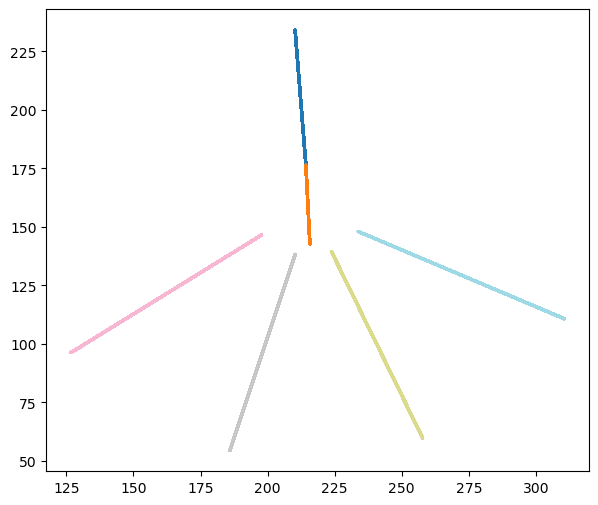

In [110]:
plt.figure(figsize=(7, 6))
plt.scatter(linear_position_df.projected_x_position, linear_position_df.projected_y_position,
            c=linear_position_df.track_segment_id, cmap='tab20', s=1)

We should also plot the linearized position itself to make sure it is okay.

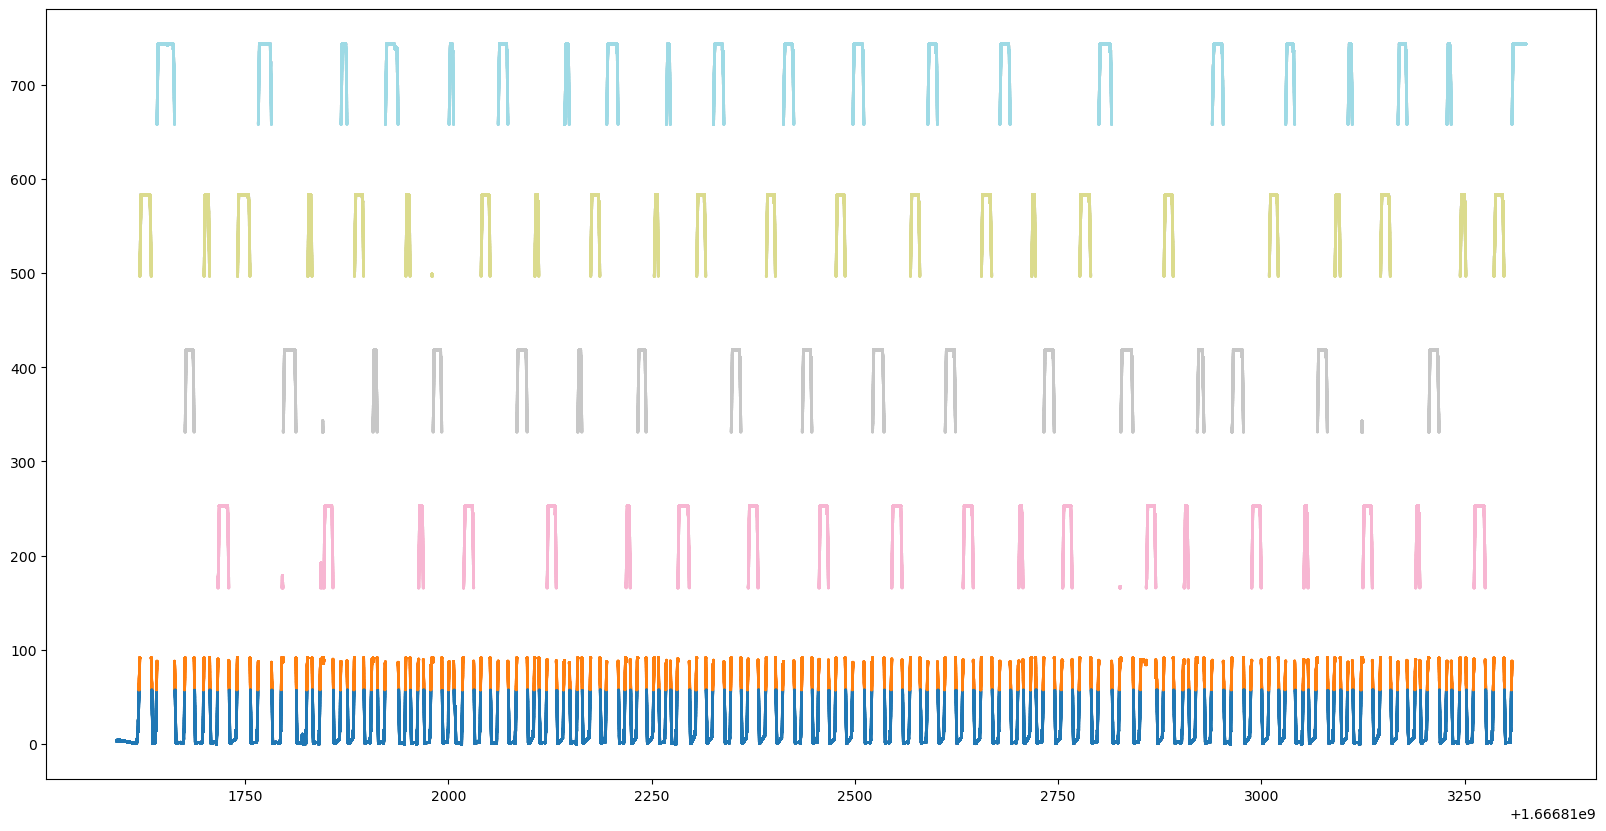

In [111]:
plt.figure(figsize=(20, 10))
plt.scatter(linear_position_df.index, linear_position_df.linear_position, s=1,
            c=linear_position_df.track_segment_id, cmap='tab20')

Okay now that we've looked at the data, we should quickly verify that all our data is the same size.

We also want to make sure we have valid ephys data and valid position data for decoding. Here we only have one valid time interval, but if we had more than one, we should decode on each interval separately.

In [50]:
intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])
marks_=[]
linear_position_df_=[]
position_df_ =[]
for i in range(len(intersect_interval)):
    valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])
    
    linear_position_df_.append(linear_position_df.loc[valid_time_slice])
    position_df_.append(position_df.loc[valid_time_slice])
    marks_.append(marks.sel(time=valid_time_slice))

marks=xr.concat(marks_,dim='time')
position_df = pd.concat(position_df_)
linear_position_df=pd.concat(linear_position_df_)
marks.shape, position_df.shape, linear_position_df.shape

((818187, 4, 15), (818187, 6), (818187, 4))

In [52]:
animal = nwb_copy_file_name[:5]
marks_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_marks.nc')
marks.to_netcdf(marks_path)

position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
linear_position_df.to_csv(position1d_path)

position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
position_df.to_csv(position2d_path)

In [55]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e],
     'marks':marks_path,
     'position_1d':position1d_path,
     'position_2d':position2d_path}
DecodeIngredients().insert1(key,replace=True)

In [93]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
DecodeIngredients() & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"
eliot20221016_.nwb,02_Seq2Session1,=BLOB=,=BLOB=,=BLOB=
eliot20221016_.nwb,04_Seq2Session2,=BLOB=,=BLOB=,=BLOB=
eliot20221016_.nwb,06_Seq2Session3,=BLOB=,=BLOB=,=BLOB=
eliot20221016_.nwb,08_Seq2Session4,=BLOB=,=BLOB=,=BLOB=


# Run All sessions

In [97]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(nwb_copy_file_name)

eliot20221017_.nwb


In [98]:
np.arange(len(session_interval))

array([0, 1, 2, 3])

In [99]:
for e in range(len(session_interval)):
    decodePrepMasterSession(nwb_copy_file_name,e,True)

0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
4
inserting into IntervalList
done inserting into IntervalList
5
inserting into IntervalList
done inserting into IntervalList
13
inserting into IntervalList
done inserting into IntervalList
14
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
23
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done insertin

[18:39:28][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:39:28 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:39:36][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:39:36 Saving sorting results...
[18:39:42][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 13, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:39:42 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 13, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:39:47][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:39:47 Saving sorting results...
[18:39:51][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 14, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:39:51 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 14, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:39:57][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:39:57 Saving sorting results...
[18:40:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:40:00 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_16_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:40:05][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:40:05 Saving sorting results...
[18:40:10][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 17, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:40:10 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 17, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_17_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:40:15][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:40:15 Saving sorting results...
[18:40:22][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 20, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:40:22 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 20, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_20_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:40:27][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:40:27 Saving sorting results...
[18:40:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 23, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:40:32 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 23, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_23_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:40:38][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:40:38 Saving sorting results...
[18:40:44][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 26, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:40:44 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 26, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_26_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:40:51][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:40:51 Saving sorting results...
[18:40:56][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 27, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:40:56 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 27, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_27_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:41:02][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:41:02 Saving sorting results...
[18:41:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:41:06 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_28_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:41:09][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:41:09 Saving sorting results...
[18:41:14][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 29, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:41:14 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 29, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_29_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:41:21][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:41:21 Saving sorting results...
[18:41:27][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:41:27 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:41:33][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:41:33 Saving sorting results...
[18:41:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:41:37 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_30_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:41:46][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:41:46 Saving sorting results...
[18:41:51][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 31, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:41:51 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 31, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_31_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:41:57][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:41:57 Saving sorting results...
[18:42:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 4, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:42:00 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 4, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_4_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:42:05][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:42:05 Saving sorting results...
[18:42:10][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 5, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:42:10 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 5, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_02_Seq2Session1_5_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1904 [00:00<?, ?it/s]

[18:42:16][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:42:16 Saving sorting results...
[18:43:33][INFO] Spyglass: Found 1 accepted units
03-Jul-24 18:43:33 Found 1 accepted units
[18:43:36][INFO] Spyglass: Writing new NWB file eliot20221017_LAAQHOB7S9.nwb
03-Jul-24 18:43:36 Writing new NWB file eliot20221017_LAAQHOB7S9.nwb
[18:43:40][INFO] Spyglass: Found 1 accepted units
03-Jul-24 18:43:40 Found 1 accepted units
[18:43:42][INFO] Spyglass: Writing new NWB file eliot20221017_M6XKBHIO7J.nwb
03-Jul-24 18:43:42 Writing new NWB file eliot20221017_M6XKBHIO7J.nwb
[18:43:49][INFO] Spyglass: Found 1 accepted units
03-Jul-24 18:43:49 Found 1 accepted units
[18:43:50][INFO] Spyglass: Writing new NWB file eliot20221017_1CBHGU5MNB.nwb
03-Jul-24 18:43:50 Writing new NWB file eliot20221017_1CBHGU5MNB.nwb
[18:43:54][INFO] Spyglass: Found 1 accepted units
03-Jul-24 18:43:54 Found 1 accepted units
[18:43:55][INFO] Spyglass: Writing new NWB file eliot20221017_SEAO716XB4.nwb
03-Jul-24 18:43:55 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:45:11][INFO] Spyglass: Writing new NWB file eliot20221017_RPNJHWL6TW.nwb
03-Jul-24 18:45:11 Writing new NWB file eliot20221017_RPNJHWL6TW.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:45:20][INFO] Spyglass: Writing new NWB file eliot20221017_S3GP9ID4BX.nwb
03-Jul-24 18:45:20 Writing new NWB file eliot20221017_S3GP9ID4BX.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:45:27][INFO] Spyglass: Writing new NWB file eliot20221017_X02XYMKZQX.nwb
03-Jul-24 18:45:27 Writing new NWB file eliot20221017_X02XYMKZQX.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:45:37][INFO] Spyglass: Writing new NWB file eliot20221017_331JAX07UD.nwb
03-Jul-24 18:45:37 Writing new NWB file eliot20221017_331JAX07UD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:45:46][INFO] Spyglass: Writing new NWB file eliot20221017_JLRUTJYS9S.nwb
03-Jul-24 18:45:46 Writing new NWB file eliot20221017_JLRUTJYS9S.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:45:55][INFO] Spyglass: Writing new NWB file eliot20221017_64LH1KDP5A.nwb
03-Jul-24 18:45:55 Writing new NWB file eliot20221017_64LH1KDP5A.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:46:02][INFO] Spyglass: Writing new NWB file eliot20221017_DRK8OK6KSE.nwb
03-Jul-24 18:46:02 Writing new NWB file eliot20221017_DRK8OK6KSE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:46:10][INFO] Spyglass: Writing new NWB file eliot20221017_T5E0NUDBFE.nwb
03-Jul-24 18:46:10 Writing new NWB file eliot20221017_T5E0NUDBFE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:46:19][INFO] Spyglass: Writing new NWB file eliot20221017_8M37U3YQDV.nwb
03-Jul-24 18:46:19 Writing new NWB file eliot20221017_8M37U3YQDV.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:46:27][INFO] Spyglass: Writing new NWB file eliot20221017_00WXMZ8CLE.nwb
03-Jul-24 18:46:27 Writing new NWB file eliot20221017_00WXMZ8CLE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:46:34][INFO] Spyglass: Writing new NWB file eliot20221017_GGO1XZ0JCK.nwb
03-Jul-24 18:46:34 Writing new NWB file eliot20221017_GGO1XZ0JCK.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:46:42][INFO] Spyglass: Writing new NWB file eliot20221017_IRNV5I4FGA.nwb
03-Jul-24 18:46:42 Writing new NWB file eliot20221017_IRNV5I4FGA.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:46:51][INFO] Spyglass: Writing new NWB file eliot20221017_PFYI4UCIE5.nwb
03-Jul-24 18:46:51 Writing new NWB file eliot20221017_PFYI4UCIE5.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:46:58][INFO] Spyglass: Writing new NWB file eliot20221017_M00PDSVHUY.nwb
03-Jul-24 18:46:58 Writing new NWB file eliot20221017_M00PDSVHUY.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:47:06][INFO] Spyglass: Writing new NWB file eliot20221017_OLO25VU392.nwb
03-Jul-24 18:47:06 Writing new NWB file eliot20221017_OLO25VU392.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:47:13][INFO] Spyglass: Writing new NWB file eliot20221017_LKSD1GPPZS.nwb
03-Jul-24 18:47:13 Writing new NWB file eliot20221017_LKSD1GPPZS.nwb
[18:47:18][INFO] Spyglass: Writing new NWB file eliot20221017_C3IQY6AI0S.nwb
03-Jul-24 18:47:18 Writing new NWB file eliot20221017_C3IQY6AI0S.nwb
[18:47:32][INFO] Spyglass: Writing new NWB file eliot20221017_F2SQKD1UAR.nwb
03-Jul-24 18:47:32 Writing new NWB file eliot20221017_F2SQKD1UAR.nwb
[18:47:46][INFO] Spyglass: Writing new NWB file eliot20221017_ZRRY85YONM.nwb
03-Jul-24 18:47:46 Writing new NWB file eliot20221017_ZRRY85YONM.nwb
[18:48:02][INFO] Spyglass: Writing new NWB file eliot20221017_K0992N2A3Z.nwb
03-Jul-24 18:48:02 Writing new NWB file eliot20221017_K0992N2A3Z.nwb
[18:48:15][INFO] Spyglass: Writing new NWB file eliot20221017_WNEL78Y62N.nwb
03-Jul-24 18:48:15 Writing new NWB file eliot20221017_WNEL78Y62N.nwb
[18:48:29][INFO] Spyglass: Writing new NWB file eliot20221017_ZHBBNVIRSJ.nwb
03-Jul-24 18:48:29 Writing new NWB file eliot20

final shape of marks and linear position df is:
(921658, 4, 16)
(921658, 4)
0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
4
inserting into IntervalList
done inserting into IntervalList
5
inserting into IntervalList
done inserting into IntervalList
13
inserting into IntervalList
done inserting into IntervalList
14
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
23
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
d

[18:51:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 0, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:51:35 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 0, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:51:40][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:51:40 Saving sorting results...
[18:51:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 13, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:51:43 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 13, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_13_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:51:49][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:51:49 Saving sorting results...
[18:51:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 14, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:51:53 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 14, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_14_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:52:00][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:52:00 Saving sorting results...
[18:52:05][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 16, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:52:05 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 16, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_16_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:52:09][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:52:09 Saving sorting results...
[18:52:15][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 17, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:52:15 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 17, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_17_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:52:23][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:52:23 Saving sorting results...
[18:52:27][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 20, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:52:27 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 20, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_20_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:52:33][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:52:33 Saving sorting results...
[18:52:38][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 23, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:52:38 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 23, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_23_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:52:43][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:52:43 Saving sorting results...
[18:52:47][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 26, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:52:47 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 26, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_26_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:52:52][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:52:52 Saving sorting results...
[18:52:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 27, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:52:58 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 27, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_27_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:53:03][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:53:03 Saving sorting results...
[18:53:07][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 28, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:53:07 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 28, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_28_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:53:13][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:53:13 Saving sorting results...
[18:53:19][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 29, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:53:19 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 29, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_29_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:53:30][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:53:30 Saving sorting results...
[18:53:34][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 2, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:53:34 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 2, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_2_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:53:41][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:53:41 Saving sorting results...
[18:53:46][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 30, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:53:46 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 30, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_30_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:53:54][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:53:54 Saving sorting results...
[18:53:59][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 31, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:53:59 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 31, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_31_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:54:05][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:54:05 Saving sorting results...
[18:54:09][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 4, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:54:09 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 4, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_4_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:54:13][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:54:13 Saving sorting results...
[18:54:18][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 5, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 18:54:18 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 5, 'sort_interval_name': '04_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_04_Seq2Session2_5_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/1956 [00:00<?, ?it/s]

[18:54:23][INFO] Spyglass: Saving sorting results...
03-Jul-24 18:54:23 Saving sorting results...
[18:55:40][INFO] Spyglass: Found 1 accepted units
03-Jul-24 18:55:40 Found 1 accepted units
[18:55:43][INFO] Spyglass: Writing new NWB file eliot20221017_WUEP9VUKLV.nwb
03-Jul-24 18:55:43 Writing new NWB file eliot20221017_WUEP9VUKLV.nwb
[18:55:46][INFO] Spyglass: Found 1 accepted units
03-Jul-24 18:55:46 Found 1 accepted units
[18:55:48][INFO] Spyglass: Writing new NWB file eliot20221017_W0SD4UHAUS.nwb
03-Jul-24 18:55:48 Writing new NWB file eliot20221017_W0SD4UHAUS.nwb
[18:55:51][INFO] Spyglass: Found 1 accepted units
03-Jul-24 18:55:51 Found 1 accepted units
[18:55:53][INFO] Spyglass: Writing new NWB file eliot20221017_TTC51VPGS5.nwb
03-Jul-24 18:55:53 Writing new NWB file eliot20221017_TTC51VPGS5.nwb
[18:55:59][INFO] Spyglass: Found 1 accepted units
03-Jul-24 18:55:59 Found 1 accepted units
[18:56:00][INFO] Spyglass: Writing new NWB file eliot20221017_PG0OGRGK6B.nwb
03-Jul-24 18:56:00 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:57:14][INFO] Spyglass: Writing new NWB file eliot20221017_JJ6FU0OO88.nwb
03-Jul-24 18:57:14 Writing new NWB file eliot20221017_JJ6FU0OO88.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:57:23][INFO] Spyglass: Writing new NWB file eliot20221017_W38AVQFKHI.nwb
03-Jul-24 18:57:23 Writing new NWB file eliot20221017_W38AVQFKHI.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:57:32][INFO] Spyglass: Writing new NWB file eliot20221017_ULHLLTQP9S.nwb
03-Jul-24 18:57:32 Writing new NWB file eliot20221017_ULHLLTQP9S.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:57:42][INFO] Spyglass: Writing new NWB file eliot20221017_8P9W9Y493W.nwb
03-Jul-24 18:57:42 Writing new NWB file eliot20221017_8P9W9Y493W.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:57:53][INFO] Spyglass: Writing new NWB file eliot20221017_MNPBM9VPJ8.nwb
03-Jul-24 18:57:53 Writing new NWB file eliot20221017_MNPBM9VPJ8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:58:02][INFO] Spyglass: Writing new NWB file eliot20221017_P7DP9LP936.nwb
03-Jul-24 18:58:02 Writing new NWB file eliot20221017_P7DP9LP936.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:58:11][INFO] Spyglass: Writing new NWB file eliot20221017_PPMGTOCMKL.nwb
03-Jul-24 18:58:11 Writing new NWB file eliot20221017_PPMGTOCMKL.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:58:20][INFO] Spyglass: Writing new NWB file eliot20221017_I4MW2STFMU.nwb
03-Jul-24 18:58:20 Writing new NWB file eliot20221017_I4MW2STFMU.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:58:29][INFO] Spyglass: Writing new NWB file eliot20221017_P5MY6OVXCP.nwb
03-Jul-24 18:58:29 Writing new NWB file eliot20221017_P5MY6OVXCP.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:58:39][INFO] Spyglass: Writing new NWB file eliot20221017_WK8LKQAIFJ.nwb
03-Jul-24 18:58:39 Writing new NWB file eliot20221017_WK8LKQAIFJ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:58:49][INFO] Spyglass: Writing new NWB file eliot20221017_D1IHL9GKF3.nwb
03-Jul-24 18:58:49 Writing new NWB file eliot20221017_D1IHL9GKF3.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:58:58][INFO] Spyglass: Writing new NWB file eliot20221017_P9QZZ9UYJ2.nwb
03-Jul-24 18:58:58 Writing new NWB file eliot20221017_P9QZZ9UYJ2.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:59:07][INFO] Spyglass: Writing new NWB file eliot20221017_LACQ6DBB73.nwb
03-Jul-24 18:59:07 Writing new NWB file eliot20221017_LACQ6DBB73.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:59:18][INFO] Spyglass: Writing new NWB file eliot20221017_G6MHCDG1EE.nwb
03-Jul-24 18:59:18 Writing new NWB file eliot20221017_G6MHCDG1EE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:59:27][INFO] Spyglass: Writing new NWB file eliot20221017_Y5CCCB4ZK8.nwb
03-Jul-24 18:59:27 Writing new NWB file eliot20221017_Y5CCCB4ZK8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[18:59:35][INFO] Spyglass: Writing new NWB file eliot20221017_H8D6DQBPW9.nwb
03-Jul-24 18:59:35 Writing new NWB file eliot20221017_H8D6DQBPW9.nwb
[18:59:40][INFO] Spyglass: Writing new NWB file eliot20221017_7I4L832SII.nwb
03-Jul-24 18:59:40 Writing new NWB file eliot20221017_7I4L832SII.nwb
[18:59:54][INFO] Spyglass: Writing new NWB file eliot20221017_TVBZLP068Q.nwb
03-Jul-24 18:59:54 Writing new NWB file eliot20221017_TVBZLP068Q.nwb
[19:00:08][INFO] Spyglass: Writing new NWB file eliot20221017_0DHU8LQ8EM.nwb
03-Jul-24 19:00:08 Writing new NWB file eliot20221017_0DHU8LQ8EM.nwb
[19:00:22][INFO] Spyglass: Writing new NWB file eliot20221017_G61FM8SSN7.nwb
03-Jul-24 19:00:22 Writing new NWB file eliot20221017_G61FM8SSN7.nwb
[19:00:38][INFO] Spyglass: Writing new NWB file eliot20221017_XU98111VOM.nwb
03-Jul-24 19:00:38 Writing new NWB file eliot20221017_XU98111VOM.nwb
[19:00:55][INFO] Spyglass: Writing new NWB file eliot20221017_G94F8BU8FS.nwb
03-Jul-24 19:00:55 Writing new NWB file eliot20

final shape of marks and linear position df is:
(949765, 4, 16)
(949765, 4)
0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
4
inserting into IntervalList
done inserting into IntervalList
5
inserting into IntervalList
done inserting into IntervalList
13
inserting into IntervalList
done inserting into IntervalList
14
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
23
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
d

[19:04:09][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 0, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:04:09 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 0, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:04:19][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:04:19 Saving sorting results...
[19:04:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 13, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:04:26 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 13, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_13_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:04:32][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:04:32 Saving sorting results...
[19:04:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 14, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:04:35 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 14, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_14_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:04:40][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:04:40 Saving sorting results...
[19:04:45][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 16, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:04:45 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 16, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_16_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:04:52][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:04:52 Saving sorting results...
[19:04:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 17, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:04:58 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 17, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_17_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:05:04][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:05:04 Saving sorting results...
[19:05:11][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 20, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:05:11 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 20, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:05:17][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:05:17 Saving sorting results...
[19:05:22][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 23, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:05:22 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 23, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_23_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:05:28][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:05:28 Saving sorting results...
[19:05:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 26, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:05:32 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 26, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_26_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:05:38][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:05:38 Saving sorting results...
[19:05:46][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 27, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:05:46 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 27, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_27_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:05:57][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:05:57 Saving sorting results...
[19:06:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 28, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:06:01 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 28, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_28_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:06:07][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:06:07 Saving sorting results...
[19:06:11][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 29, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:06:11 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 29, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_29_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:06:15][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:06:15 Saving sorting results...
[19:06:19][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 2, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:06:19 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 2, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:06:26][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:06:26 Saving sorting results...
[19:06:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 30, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:06:31 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 30, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_30_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:06:37][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:06:37 Saving sorting results...
[19:06:44][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 31, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:06:44 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 31, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_31_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:06:52][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:06:52 Saving sorting results...
[19:06:57][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 4, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:06:57 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 4, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_4_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:07:02][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:07:02 Saving sorting results...
[19:07:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 5, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:07:06 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 5, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_06_Seq2Session3_5_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2027 [00:00<?, ?it/s]

[19:07:12][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:07:12 Saving sorting results...
[19:08:27][INFO] Spyglass: Found 1 accepted units
03-Jul-24 19:08:27 Found 1 accepted units
[19:08:30][INFO] Spyglass: Writing new NWB file eliot20221017_TPKK0B6ODZ.nwb
03-Jul-24 19:08:30 Writing new NWB file eliot20221017_TPKK0B6ODZ.nwb
[19:08:34][INFO] Spyglass: Found 1 accepted units
03-Jul-24 19:08:34 Found 1 accepted units
[19:08:36][INFO] Spyglass: Writing new NWB file eliot20221017_8TH5511EO0.nwb
03-Jul-24 19:08:36 Writing new NWB file eliot20221017_8TH5511EO0.nwb
[19:08:40][INFO] Spyglass: Found 1 accepted units
03-Jul-24 19:08:40 Found 1 accepted units
[19:08:42][INFO] Spyglass: Writing new NWB file eliot20221017_DR89K0RW0A.nwb
03-Jul-24 19:08:42 Writing new NWB file eliot20221017_DR89K0RW0A.nwb
[19:08:46][INFO] Spyglass: Found 1 accepted units
03-Jul-24 19:08:46 Found 1 accepted units
[19:08:48][INFO] Spyglass: Writing new NWB file eliot20221017_AHGDXE6CUU.nwb
03-Jul-24 19:08:48 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:10:17][INFO] Spyglass: Writing new NWB file eliot20221017_9589QS5BMW.nwb
03-Jul-24 19:10:17 Writing new NWB file eliot20221017_9589QS5BMW.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:10:27][INFO] Spyglass: Writing new NWB file eliot20221017_LCAH51Z764.nwb
03-Jul-24 19:10:27 Writing new NWB file eliot20221017_LCAH51Z764.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:10:37][INFO] Spyglass: Writing new NWB file eliot20221017_194E4CF5ZK.nwb
03-Jul-24 19:10:37 Writing new NWB file eliot20221017_194E4CF5ZK.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:10:46][INFO] Spyglass: Writing new NWB file eliot20221017_59PZJP74ZP.nwb
03-Jul-24 19:10:46 Writing new NWB file eliot20221017_59PZJP74ZP.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:10:59][INFO] Spyglass: Writing new NWB file eliot20221017_QB3IIR3NTU.nwb
03-Jul-24 19:10:59 Writing new NWB file eliot20221017_QB3IIR3NTU.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:11:09][INFO] Spyglass: Writing new NWB file eliot20221017_4TR6Q02VCZ.nwb
03-Jul-24 19:11:09 Writing new NWB file eliot20221017_4TR6Q02VCZ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:11:19][INFO] Spyglass: Writing new NWB file eliot20221017_0PGIXQ991K.nwb
03-Jul-24 19:11:19 Writing new NWB file eliot20221017_0PGIXQ991K.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:11:31][INFO] Spyglass: Writing new NWB file eliot20221017_T640MHGU9Z.nwb
03-Jul-24 19:11:31 Writing new NWB file eliot20221017_T640MHGU9Z.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:11:42][INFO] Spyglass: Writing new NWB file eliot20221017_XRJ2H9CICV.nwb
03-Jul-24 19:11:42 Writing new NWB file eliot20221017_XRJ2H9CICV.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:11:52][INFO] Spyglass: Writing new NWB file eliot20221017_27E3ATY6X2.nwb
03-Jul-24 19:11:52 Writing new NWB file eliot20221017_27E3ATY6X2.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:12:02][INFO] Spyglass: Writing new NWB file eliot20221017_X9XVZLV2QE.nwb
03-Jul-24 19:12:02 Writing new NWB file eliot20221017_X9XVZLV2QE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:12:12][INFO] Spyglass: Writing new NWB file eliot20221017_6PIKG8M97X.nwb
03-Jul-24 19:12:12 Writing new NWB file eliot20221017_6PIKG8M97X.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:12:21][INFO] Spyglass: Writing new NWB file eliot20221017_GCROUPY2U1.nwb
03-Jul-24 19:12:21 Writing new NWB file eliot20221017_GCROUPY2U1.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:12:31][INFO] Spyglass: Writing new NWB file eliot20221017_VUWKVISK87.nwb
03-Jul-24 19:12:31 Writing new NWB file eliot20221017_VUWKVISK87.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:12:40][INFO] Spyglass: Writing new NWB file eliot20221017_XI2CHT12YD.nwb
03-Jul-24 19:12:40 Writing new NWB file eliot20221017_XI2CHT12YD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:12:51][INFO] Spyglass: Writing new NWB file eliot20221017_KK84PHZBUV.nwb
03-Jul-24 19:12:51 Writing new NWB file eliot20221017_KK84PHZBUV.nwb
[19:12:56][INFO] Spyglass: Writing new NWB file eliot20221017_WEA7MK2M8T.nwb
03-Jul-24 19:12:56 Writing new NWB file eliot20221017_WEA7MK2M8T.nwb
[19:13:11][INFO] Spyglass: Writing new NWB file eliot20221017_3PPZGVB8TU.nwb
03-Jul-24 19:13:11 Writing new NWB file eliot20221017_3PPZGVB8TU.nwb
[19:13:25][INFO] Spyglass: Writing new NWB file eliot20221017_VDZOVFYKQK.nwb
03-Jul-24 19:13:25 Writing new NWB file eliot20221017_VDZOVFYKQK.nwb
[19:13:39][INFO] Spyglass: Writing new NWB file eliot20221017_VK0MMXD8T7.nwb
03-Jul-24 19:13:39 Writing new NWB file eliot20221017_VK0MMXD8T7.nwb
[19:13:53][INFO] Spyglass: Writing new NWB file eliot20221017_6CH9JEDEEW.nwb
03-Jul-24 19:13:53 Writing new NWB file eliot20221017_6CH9JEDEEW.nwb
[19:14:07][INFO] Spyglass: Writing new NWB file eliot20221017_KIWNBEKFC6.nwb
03-Jul-24 19:14:07 Writing new NWB file eliot20

final shape of marks and linear position df is:
(983109, 4, 16)
(983109, 4)
0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
4
inserting into IntervalList
done inserting into IntervalList
5
inserting into IntervalList
done inserting into IntervalList
13
inserting into IntervalList
done inserting into IntervalList
14
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
23
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
d

[19:17:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 0, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:17:30 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 0, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:17:36][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:17:36 Saving sorting results...
[19:17:40][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 13, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:17:40 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 13, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_13_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:17:45][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:17:45 Saving sorting results...
[19:17:51][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 14, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:17:51 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 14, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_14_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:17:58][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:17:58 Saving sorting results...
[19:18:04][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 16, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:18:04 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 16, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_16_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:18:10][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:18:10 Saving sorting results...
[19:18:15][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 17, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:18:15 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 17, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_17_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:18:27][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:18:27 Saving sorting results...
[19:18:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 20, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:18:30 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 20, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_20_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:18:39][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:18:39 Saving sorting results...
[19:18:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 23, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:18:43 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 23, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_23_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:18:50][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:18:50 Saving sorting results...
[19:18:55][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 26, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:18:55 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 26, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_26_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:19:02][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:19:02 Saving sorting results...
[19:19:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 27, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:19:08 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 27, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_27_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:19:27][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:19:27 Saving sorting results...
[19:19:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 28, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:19:32 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 28, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_28_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:19:37][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:19:37 Saving sorting results...
[19:19:41][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 29, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:19:41 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 29, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_29_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:19:47][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:19:47 Saving sorting results...
[19:19:51][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 2, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:19:51 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 2, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_2_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:19:58][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:19:58 Saving sorting results...
[19:20:02][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 30, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:20:02 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 30, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_30_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:20:10][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:20:10 Saving sorting results...
[19:20:14][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 31, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:20:14 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 31, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_31_franklab_tetrode_hippocampus_ampl_1500_pro

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:20:19][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:20:19 Saving sorting results...
[19:20:23][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 4, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:20:23 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 4, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_4_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:20:29][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:20:29 Saving sorting results...
[19:20:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 5, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-Jul-24 19:20:33 Running spike sorting on {'nwb_file_name': 'eliot20221017_.nwb', 'sort_group_id': 5, 'sort_interval_name': '08_Seq2Session4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'eliot20221017_.nwb_08_Seq2Session4_5_franklab_tetrode_hippocampus_ampl_1500_prop_07

detect peaks using locally_exclusive:   0%|          | 0/2067 [00:00<?, ?it/s]

[19:20:38][INFO] Spyglass: Saving sorting results...
03-Jul-24 19:20:38 Saving sorting results...
[19:21:54][INFO] Spyglass: Found 1 accepted units
03-Jul-24 19:21:54 Found 1 accepted units
[19:21:56][INFO] Spyglass: Writing new NWB file eliot20221017_NQSODRN4GS.nwb
03-Jul-24 19:21:56 Writing new NWB file eliot20221017_NQSODRN4GS.nwb
[19:22:00][INFO] Spyglass: Found 1 accepted units
03-Jul-24 19:22:00 Found 1 accepted units
[19:22:02][INFO] Spyglass: Writing new NWB file eliot20221017_LYR79YZ3LN.nwb
03-Jul-24 19:22:02 Writing new NWB file eliot20221017_LYR79YZ3LN.nwb
[19:22:06][INFO] Spyglass: Found 1 accepted units
03-Jul-24 19:22:06 Found 1 accepted units
[19:22:07][INFO] Spyglass: Writing new NWB file eliot20221017_Z346JUNVNG.nwb
03-Jul-24 19:22:07 Writing new NWB file eliot20221017_Z346JUNVNG.nwb
[19:22:11][INFO] Spyglass: Found 1 accepted units
03-Jul-24 19:22:11 Found 1 accepted units
[19:22:13][INFO] Spyglass: Writing new NWB file eliot20221017_L2BPN5ESM1.nwb
03-Jul-24 19:22:13 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:23:37][INFO] Spyglass: Writing new NWB file eliot20221017_31C35Z7C7F.nwb
03-Jul-24 19:23:37 Writing new NWB file eliot20221017_31C35Z7C7F.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:23:49][INFO] Spyglass: Writing new NWB file eliot20221017_TM28QODU64.nwb
03-Jul-24 19:23:49 Writing new NWB file eliot20221017_TM28QODU64.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:23:57][INFO] Spyglass: Writing new NWB file eliot20221017_YIOBT6A5XZ.nwb
03-Jul-24 19:23:57 Writing new NWB file eliot20221017_YIOBT6A5XZ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:24:06][INFO] Spyglass: Writing new NWB file eliot20221017_PQDRYW5FZY.nwb
03-Jul-24 19:24:06 Writing new NWB file eliot20221017_PQDRYW5FZY.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:24:16][INFO] Spyglass: Writing new NWB file eliot20221017_SOB58XIWXK.nwb
03-Jul-24 19:24:16 Writing new NWB file eliot20221017_SOB58XIWXK.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:24:25][INFO] Spyglass: Writing new NWB file eliot20221017_6B8KDTUJ2W.nwb
03-Jul-24 19:24:25 Writing new NWB file eliot20221017_6B8KDTUJ2W.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:24:34][INFO] Spyglass: Writing new NWB file eliot20221017_ZTZ525WQ8G.nwb
03-Jul-24 19:24:34 Writing new NWB file eliot20221017_ZTZ525WQ8G.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:24:42][INFO] Spyglass: Writing new NWB file eliot20221017_IYXDAGSRDC.nwb
03-Jul-24 19:24:42 Writing new NWB file eliot20221017_IYXDAGSRDC.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:24:51][INFO] Spyglass: Writing new NWB file eliot20221017_OWTTCV9Q2E.nwb
03-Jul-24 19:24:51 Writing new NWB file eliot20221017_OWTTCV9Q2E.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:25:01][INFO] Spyglass: Writing new NWB file eliot20221017_RHRKPATVSI.nwb
03-Jul-24 19:25:01 Writing new NWB file eliot20221017_RHRKPATVSI.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:25:11][INFO] Spyglass: Writing new NWB file eliot20221017_HQVR1Z28OQ.nwb
03-Jul-24 19:25:11 Writing new NWB file eliot20221017_HQVR1Z28OQ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:25:21][INFO] Spyglass: Writing new NWB file eliot20221017_N0LIELBH6G.nwb
03-Jul-24 19:25:21 Writing new NWB file eliot20221017_N0LIELBH6G.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:25:30][INFO] Spyglass: Writing new NWB file eliot20221017_A555LCPHIB.nwb
03-Jul-24 19:25:30 Writing new NWB file eliot20221017_A555LCPHIB.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:25:39][INFO] Spyglass: Writing new NWB file eliot20221017_ZUL6Q61VQO.nwb
03-Jul-24 19:25:39 Writing new NWB file eliot20221017_ZUL6Q61VQO.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:25:47][INFO] Spyglass: Writing new NWB file eliot20221017_V7WNVQF29J.nwb
03-Jul-24 19:25:47 Writing new NWB file eliot20221017_V7WNVQF29J.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:25:56][INFO] Spyglass: Writing new NWB file eliot20221017_M0CWOZGPRO.nwb
03-Jul-24 19:25:56 Writing new NWB file eliot20221017_M0CWOZGPRO.nwb
[19:26:01][INFO] Spyglass: Writing new NWB file eliot20221017_SIG75N3Z0N.nwb
03-Jul-24 19:26:01 Writing new NWB file eliot20221017_SIG75N3Z0N.nwb
[19:26:16][INFO] Spyglass: Writing new NWB file eliot20221017_N9X03W1S7P.nwb
03-Jul-24 19:26:16 Writing new NWB file eliot20221017_N9X03W1S7P.nwb
[19:26:30][INFO] Spyglass: Writing new NWB file eliot20221017_XHWY9T425Z.nwb
03-Jul-24 19:26:30 Writing new NWB file eliot20221017_XHWY9T425Z.nwb
[19:26:44][INFO] Spyglass: Writing new NWB file eliot20221017_0OYXS9LQYP.nwb
03-Jul-24 19:26:44 Writing new NWB file eliot20221017_0OYXS9LQYP.nwb
[19:27:01][INFO] Spyglass: Writing new NWB file eliot20221017_DLR119IYB0.nwb
03-Jul-24 19:27:01 Writing new NWB file eliot20221017_DLR119IYB0.nwb
[19:27:15][INFO] Spyglass: Writing new NWB file eliot20221017_M3HRP7EPKD.nwb
03-Jul-24 19:27:15 Writing new NWB file eliot20

final shape of marks and linear position df is:
(943754, 4, 16)
(943754, 4)


In [ ]:
%debug

> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/IPython/core/compilerop.py(86)ast_parse()
     84         Arguments are exactly the same as ast.parse (in the standard library),
     85         and are passed to the built-in compile function."""
---> 86         return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
     87 
     88     def reset_compiler_flags(self):



ipdb>  up


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3280)run_cell_async()
   3278                 # Compile to bytecode
   3279                 try:
-> 3280                     code_ast = compiler.ast_parse(cell, filename=cell_name)
   3281                 except self.custom_exceptions as e:
   3282                     etype, value, tb = sys.exc_info()



ipdb>  up


*** Oldest frame


ipdb>  up


*** Oldest frame


In [83]:
#(Curation & key).delete()

In [100]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name}
DecodeIngredients() & key

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"
eliot20221017_.nwb,02_Seq2Session1,=BLOB=,=BLOB=,=BLOB=
eliot20221017_.nwb,04_Seq2Session2,=BLOB=,=BLOB=,=BLOB=
eliot20221017_.nwb,06_Seq2Session3,=BLOB=,=BLOB=,=BLOB=
eliot20221017_.nwb,08_Seq2Session4,=BLOB=,=BLOB=,=BLOB=


# END HERE

In [59]:
## try loading
nwb_copy_file_name = 'eliot20221021_.nwb'

In [44]:
e=0

In [45]:
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e]}
marks = xr.open_dataset(entry.fetch1('marks'))
position_1d = pd.read_csv(entry.fetch1('position_1d'))
position_2d = pd.read_csv(entry.fetch1('position_2d'))

In [46]:
marks

<xarray.Dataset>
Dimensions:                        (time: 958279, marks: 4, electrodes: 15)
Coordinates:
  * time                           (time) float64 1.667e+09 ... 1.667e+09
  * electrodes                     (electrodes) int32 0 2 4 5 13 ... 28 29 30 31
  * marks                          (marks) object 'amplitude_0000' ... 'ampli...
Data variables:
    __xarray_dataarray_variable__  (time, marks, electrodes) float32 ...

In [47]:
for e in range(len(session_interval)):
    """
    Position: UnitMarksIndicator
    """
    linear_position_df = (IntervalLinearizedPosition() &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
        ).fetch1_dataframe()
    position_df = (IntervalPositionInfo &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
                    ).fetch1_dataframe()

    # Remove Data before 1st trial and after last trial
    StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,
                        'epoch_name':session_interval[e]}).fetch1('choice_reward'))

    trial_1_t = StateScript.loc[1].timestamp_O
    trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
    linear_position_df = removeDataBeforeTrial1(linear_position_df,trial_1_t,trial_last_t)
    position_df = removeDataBeforeTrial1(position_df,trial_1_t,trial_last_t)

    """
    Intervals
    """
    intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])

    linear_position_df_=[]
    position_df_ =[]
    for i in range(len(intersect_interval)):
        valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])

        linear_position_df_.append(linear_position_df.loc[valid_time_slice])
        position_df_.append(position_df.loc[valid_time_slice])


    linear_position_df=pd.concat(linear_position_df_)
    position_df=pd.concat(position_df_)
    print('final shape of marks and linear position df is:')

    print(linear_position_df.shape)

    """save result"""
    animal = nwb_copy_file_name[:5]


    position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
    linear_position_df.to_csv(position1d_path)

    position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
    position_df.to_csv(position2d_path)

[09:47:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:09 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(958279, 4)


[09:47:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:22 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(885994, 4)


[09:47:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:34 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(843218, 4)


[09:47:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:46 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(783223, 4)
